<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Implementando una red neuronal recurrente simple<a id="top"></a>

<i><small>Autor: Alberto Díaz Álvarez<br>Última actualización: 2023-03-14</small></i></div>
                                                  

***

## Introducción

Las unidades recurrentes simples (SRU, del inglés _Single Recurrent Unit_) son a las Redes Neuronales Recurrentes (RNNs) lo que las neuronas a las Redes Neuronales tradicionales. La única diferencia es que la salida de la red se concatena a la entrada, de tal manera que la salida anterior forma parte de la entrada actual.

## Objetivos

En este _notebook_ vamos a implementar una red neuronal recurrente para resolver el problema [MNIST](http://yann.lecun.com/exdb/mnist/). En realidad lo haremos más como ejercicio que como probelma de aplicación real, ya que técnicamente el MNIST es un problema de reconocimiento de imagen. Sin embargo, como veremos, las RNNs, leyendo las columnas de izquierda a derecha de la imagen de los números son capaces de alcanzar resultados equiparables a los de las Redes de Convolución (CNNs).

Al finalizar habremos aprendido a:

- Crear y entrenar un modelo recurrente para la resolución de problemas de clasificación usando, para ello, una SRU.
- Apilar dos o más SRU para hacer Redes Recurrentes multicapa, aumentando así la potencia de estas redes

## Imports y configuración

A continuación importaremos las librerías que se usarán a lo largo del notebook.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical

Asímismo, configuramos algunos parámetros para adecuar la presentación gráfica.

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

***

## Descarga y preprocesamiento de datos

Empezamos como en el resto de notebooks, descargando y preparando el conjunto `mnist` para nuestra tarea.

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train, x_test = x_train / 255, x_test / 255
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

## Modelo basado en una capa de SRUs

La primera capa será una SRU (en keras una `SimpleRNN`) de 10 "unidades" (una salida de dimensión 10) y cuya entrada sean las dimensiones de la imagen (esto es, $28 \times 28$).

La segunda capa será una densa con activación softmax para las 10 posibles salidas. Esto quiere decir que los 10 valores de salida de nuestra SRU se conectarán con 10 neuronas haciendo un total de 110 conexiones (10 * 10 + 10 de bias).

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(10, input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                390       
                                                                 
 dense (Dense)               (None, 10)                110       
                                                                 
Total params: 500
Trainable params: 500
Non-trainable params: 0
_________________________________________________________________


Estamos indicando una entrada de $28 \times 28$, pero que no nos lleve a engaño. No estamos ofreciendo una entrada de 28 filas por 28 columnas; estamos ofreciendo una entrada de 28 elementos de una secuencia, cada uno de tamaño 28. Es decir, se va a alimentar a nuestra red primero con la primera fila de la imagen, luego con la segunda, luego con la tercera, y así sucesivamente hasta la fila número 28.

Por último, vamos a compilar el modelo creado con la función de pérdida que corresponde a este tipo de problema con un optimizador de descenso del gradiente estocástico y vamos a añadir la métrica de _exactitud_ para ver cómo evoluciona dicho entrenamiento.

In [5]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

### Entrenamiento del modelo

Por último, entrenaremos nuestra red durante $10$ epochs (sí, las redes recurentes son muuucho más lentas de entrenar que otras). Vamos además a usar un conjunto de validación de un 10% del conjunto de entrenamiento para ver la evolución.

In [6]:
history = model.fit(x_train, y_train, epochs=10, validation_split=0.1)

Epoch 1/10
1688/1688 [==============================] - 6s 3ms/step - loss: 1.7267 - categorical_accuracy: 0.3753 - val_loss: 1.4613 - val_categorical_accuracy: 0.4743
Epoch 2/10
1688/1688 [==============================] - 5s 3ms/step - loss: 1.4276 - categorical_accuracy: 0.4987 - val_loss: 1.3242 - val_categorical_accuracy: 0.5542
Epoch 3/10
1688/1688 [==============================] - 5s 3ms/step - loss: 1.3114 - categorical_accuracy: 0.5475 - val_loss: 1.1630 - val_categorical_accuracy: 0.5985
Epoch 4/10
1688/1688 [==============================] - 5s 3ms/step - loss: 1.1893 - categorical_accuracy: 0.5892 - val_loss: 1.0250 - val_categorical_accuracy: 0.6412
Epoch 5/10
1688/1688 [==============================] - 5s 3ms/step - loss: 1.1089 - categorical_accuracy: 0.6132 - val_loss: 0.9797 - val_categorical_accuracy: 0.6545
Epoch 6/10
1688/1688 [==============================] - 5s 3ms/step - loss: 1.0670 - categorical_accuracy: 0.6273 - val_loss: 0.9209 - val_categorical_accuracy:

Ahora, para ver cómo ha evolucionado el entrenamiento, vamos a mostrar dos gráficas, una al lado de la otra, con los datos de entrenamiento de pérdida y exactitud tanto en el conjunto de entrenamiento como en el de test.

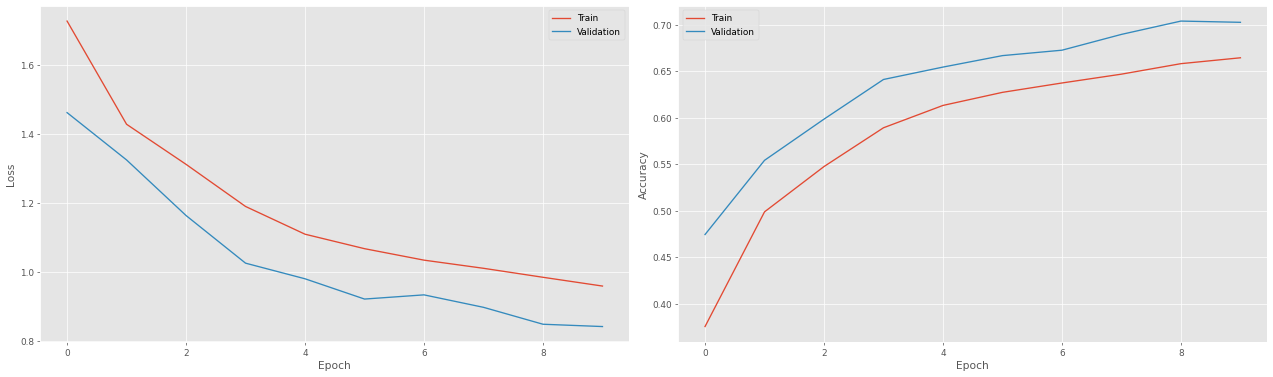

In [7]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Train')
plt.plot(history.history['val_categorical_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Podemos observar que distan de las precisiones alcanzadas con otras técnicas de deep learning, sobre todo comparando con las redes de convolución. Pero como hemos dicho, es un ejemplo de implementación, no un caso de uso específico.

### Clasificación de dígitos

Vamos a sacar una inferencia de un ejemplo en concreto. Concretamente, vamos a sacar por pantalla el dígito como figura y la predicción.

1/1 [==============================] - 1s 630ms/step


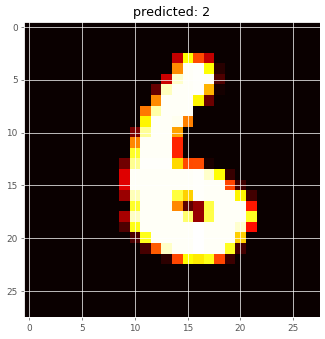

In [8]:
example = x_train[36]

predicted = model.predict(np.array([example]))
                          
plt.imshow(example, cmap='hot')
plt.title(f'predicted: {np.argmax(predicted)}')
plt.show()

## Apilando redes

Las redes recurrentes ya se consideran _aprendizaje profundo_, aunque existe el concepto de las _redes recurrentes profundas_, lo cual es simplemente apilar unidades recurrentes para aumentar la complejidad del modelo. Otra forma de llamarlas es _stacked networks_.

Vamos a crear un modelo con varias unidades recurrentes apiladas (digamos 3 capas). Los datos de compilación podemos dejarlos como en el anterior ejemplo.

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(16, return_sequences=True, input_shape=(28, 28)),
    tf.keras.layers.SimpleRNN(8, return_sequences=True),
    tf.keras.layers.SimpleRNN(4),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 28, 16)            720       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 28, 8)             200       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 4)                 52        
                                                                 
 dense_1 (Dense)             (None, 10)                50        
                                                                 
Total params: 1,022
Trainable params: 1,022
Non-trainable params: 0
_________________________________________________________________


Si nos fijamos, hemos devuelto los valores como secuencia en todas menos la última capa recurente. Esto es así porque nuestra SRU **espera las entradas como secuencia**. Si no lo pusiésemos, únicamente devolvería un valor y no se le podría pasar una secuencia de elementos los primeros.

Ahora, pasaremos a realizar un entrenamiento sobre este modelo con los mismos parámetros que el anterior ejemplo

In [10]:
history = model.fit(x_train, y_train, epochs=10, validation_split=0.1)

Epoch 1/10
1688/1688 [==============================] - 33s 17ms/step - loss: 1.6385 - categorical_accuracy: 0.4318 - val_loss: 1.2469 - val_categorical_accuracy: 0.5737
Epoch 2/10
1688/1688 [==============================] - 26s 15ms/step - loss: 1.1753 - categorical_accuracy: 0.5923 - val_loss: 1.0104 - val_categorical_accuracy: 0.6517
Epoch 3/10
1688/1688 [==============================] - 16s 10ms/step - loss: 1.0021 - categorical_accuracy: 0.6709 - val_loss: 0.8447 - val_categorical_accuracy: 0.7397
Epoch 4/10
1688/1688 [==============================] - 16s 9ms/step - loss: 0.8971 - categorical_accuracy: 0.7085 - val_loss: 0.7716 - val_categorical_accuracy: 0.7517
Epoch 5/10
1688/1688 [==============================] - 16s 9ms/step - loss: 0.8310 - categorical_accuracy: 0.7254 - val_loss: 0.7271 - val_categorical_accuracy: 0.7557
Epoch 6/10
1688/1688 [==============================] - 16s 9ms/step - loss: 0.7831 - categorical_accuracy: 0.7386 - val_loss: 0.6967 - val_categorical_

Veamos la evolución del _loss_ y la exactitud.

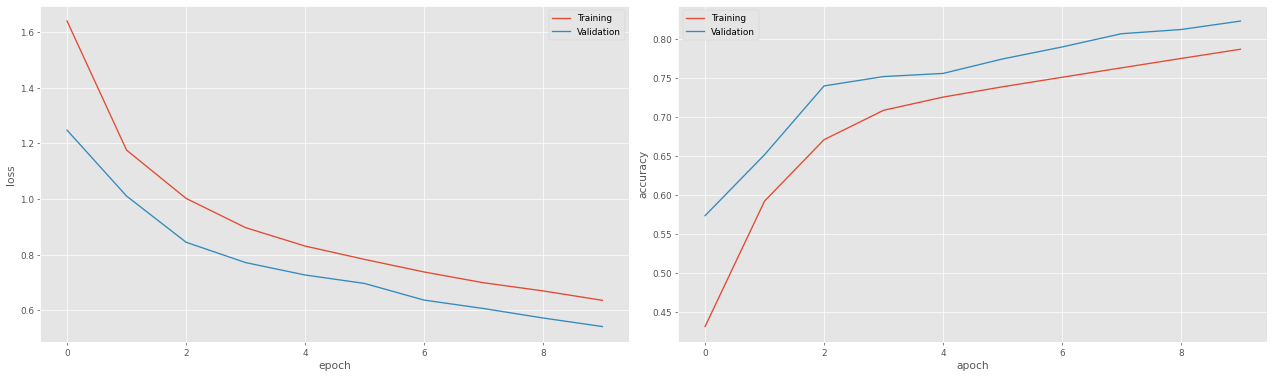

In [11]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training')
plt.plot(history.history['val_categorical_accuracy'], label='Validation')
plt.ylabel('accuracy')
plt.xlabel('apoch')
plt.legend()

plt.tight_layout()
plt.show()

Y hasta aquí el notebook. Hemos visto que crear una red neuronal recurrente es tan sencillo como crear una red normal, y que en el caso de querer tener varias unidades apiladas hay que añadir un mínimo cambio.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>